# Doublet rate calculation

This documentation shows how doublet rates are calculated for each cluster.

## Step 1: Merge samples per source and carry out integration

### Step 1.1: Merge matrices

One can use the Snakemake pipeline like that in `scripts/Snakefile_mm_merge` to merge matrices of all samples per source together.

### Step 1.2: Filter genes and integrate matrices

At this step, we reduce the genes included in the analysis from all genes to non-duplicate protein coding genes. The matrices and feature files can be filtered using `mm subset`. Next, we integrate samples per source using Seurat and Harmony, correcting for `"sex", "bmi", "age", "chemistry", "study", "treatments"`. One can use the Snakemake pipeline like that in `scripts/Snakefile_integrate` to carry out this analysis. Of note, these scripts will require appropriate changes in files and paths.

## Step 2: Calculate doublet rates

In [ ]:
library(Seurat)
library(ggplot2)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(S4Vectors))
suppressPackageStartupMessages(library(GenomicRanges))
library(patchwork)
library(biomaRt)
library(harmony)
library(reticulate)

In [ ]:
markers <- c('INS', 'IAPP', #Beta
             'GCG', #Alpha
             'SST', #Delta
             'PPY', #Gamma
             'GHRL', #Epsilon
             'CFTR', #Ductal
             'MUC5B', #MUC5B+ Ductal
             'REG1A', 'CTRB2', 'PRSS1', 'PRSS2', "CPA1", #Acinar
             'PDGFRB', 'COL6A1', 'RGS5', #Stellate
             'PLVAP','ESAM','VWF', #Endothelial
             'KIT', #Mast
             'CD69','C1QB', 'C1QC', 'C1QA', #Immune (Macrophages),
             'MKI67','CDK1') #Dividing cells

In [ ]:
# doublet finder results round 2
files <- list.files("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round2/nonDup_proteinCoding/doubletfinder/", pattern = "txt")
dblf <- data.frame("barcodes" = NA, "doubletfinder" = NA, "donor" = NA)
for (i in files) {
    donor <- gsub(".doubletfinder_assignments.txt", "", i)
    df <- read.table(paste0("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round2/nonDup_proteinCoding/doubletfinder/", i), header = F)
    colnames(df) <- c("barcodes", "doubletfinder")
    df$donor <- donor
    dblf <- rbind(dblf, df)
}
dblf$barcodes <- paste0(dblf$donor, "-", dblf$barcodes)
dblf <- dblf[!is.na(dblf$doubletfinder),]
dblf <- dblf[dblf$doubletfinder == "doublet",]
head(dblf)

### HPAP

In [ ]:
rna <- readRDS("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round1/nonDup_proteinCoding/HPAP.rna.rds")
rna

This Rds object already has a column named `doubletfinder` which contains DoubletFinder round 1 results (see code from Step 1.2). Next, we create a column named `to_remove` that contains doublets called from both rounds.

In [ ]:
rna@meta.data$to_remove <- ifelse(rna@meta.data$doubletfinder == "doublet", 1, 0)
rna@meta.data$to_remove <- ifelse(rna@meta.data$rownames %in% dblf$barcodes, 1, rna@meta.data$to_remove)
table(rna@meta.data$to_remove)

In [ ]:
Idents(rna) <- as.factor(rna@meta.data$`RNA_snn_res.1.8`) # make sure we use res = 1.8 for doublet rates
Idents(rna) <- factor(Idents(rna), levels=1:max(as.numeric(Idents(rna))))
rna$seurat_clusters <- factor(Idents(rna), levels=1:max(as.numeric(Idents(rna))))

In [ ]:
options(repr.plot.width = 17, repr.plot.height = 7, repr.plot.res = 300)

DotPlot(rna, features = markers, cluster.idents = TRUE, col.min = 0, scale = T) +
  theme(axis.text.x = element_text(angle = -45, hjust = 0)) + coord_flip() + ggtitle("HPAP res 1.8")

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
DimPlot(rna, label = T, repel = T) + ggtitle("HPAP res 1.8")

In [ ]:
p1 <- DimPlot(rna, label = F) + ggtitle(paste0("HPAP res 1.8"))
p2 <- DimPlot(rna, label = F, group.by = "to_remove") + ggtitle("doublets")
p <- FeaturePlot(rna, features = markers) + p1 + p2

options(repr.plot.width = 18, repr.plot.height = 18, repr.plot.res = 300)
p

In [ ]:
ggData = data.frame(prop.table(table(rna$to_remove, rna$`RNA_snn_res.1.8`), margin = 2))
colnames(ggData) = c("doublets", "cluster", "value")
head(ggData)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
ggData = data.frame(prop.table(table(rna$to_remove, rna$`RNA_snn_res.1.8`), margin = 2))
colnames(ggData) = c("doublets", "cluster", "value")
ggplot(ggData[ggData$doublets == 1,], aes(cluster, value*100, fill = doublets)) +
  geom_col() + xlab("Cluster") + ylab("Proportion of Cells (%)") + ggtitle("HPAP, res 1.8") + 
  theme(axis.text.x = element_text(angle = -45, hjust = 0)) + 
  geom_hline(yintercept = 55, linetype = "dotdash")

In [ ]:
ggData[ggData$doublets == 1 & ggData$value > 0.55, "cluster"]

In [ ]:
rna@meta.data$to_remove <- ifelse(rna@meta.data$`RNA_snn_res.1.8` %in% c(16, 20, 21, 27, 33, 45, 49),
                                  1, rna@meta.data$to_remove)

In [ ]:
write.table(rna@meta.data[rna@meta.data$to_remove == 1, "rownames"],
            paste0("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round1/nonDup_proteinCoding/HPAP_indivDblts.txt"), quote = F, sep = "\t", row.names = F)

### IIDP

In [ ]:
rna <- readRDS("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round1/nonDup_proteinCoding/IIDP.rna.rds")
rna

In [ ]:
rna@meta.data$to_remove <- ifelse(rna@meta.data$doubletfinder == "doublet", 1, 0)
rna@meta.data$to_remove <- ifelse(rna@meta.data$rownames %in% dblf$barcodes, 1, rna@meta.data$to_remove)
table(rna@meta.data$to_remove)

In [ ]:
Idents(rna) <- as.factor(rna@meta.data$`RNA_snn_res.1.8`)
Idents(rna) <- factor(Idents(rna), levels=1:max(as.numeric(Idents(rna))))
rna$seurat_clusters <- factor(Idents(rna), levels=1:max(as.numeric(Idents(rna))))

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 8, repr.plot.res = 300)

DotPlot(rna, features = markers, cluster.idents = TRUE, col.min = 0, scale = T) +
  theme(axis.text.x = element_text(angle = -45, hjust = 0)) + coord_flip() + ggtitle("IIDP res 1.8")

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300)
DimPlot(rna, label = T, repel = T) + ggtitle("IIDP res 1.8")

In [ ]:
p1 <- DimPlot(rna, label = F) + ggtitle(paste0("IIDP res 1.8"))
p2 <- DimPlot(rna, label = F, group.by = "to_remove") + ggtitle("doublets")
p <- FeaturePlot(rna, features = markers) + p1 + p2

options(repr.plot.width = 18, repr.plot.height = 18, repr.plot.res = 300)
p

In [ ]:
ggData = data.frame(prop.table(table(rna$to_remove, rna$`RNA_snn_res.1.8`), margin = 2))
colnames(ggData) = c("doublets", "cluster", "value")
head(ggData)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
ggData = data.frame(prop.table(table(rna$to_remove, rna$`RNA_snn_res.1.8`), margin = 2))
colnames(ggData) = c("doublets", "cluster", "value")
ggplot(ggData[ggData$doublets == 1,], aes(cluster, value*100, fill = doublets)) +
  geom_col() + xlab("Cluster") + ylab("Proportion of Cells (%)") + ggtitle("IIDP, res 1.8") + 
  theme(axis.text.x = element_text(angle = -45, hjust = 0)) + 
  geom_hline(yintercept = 55, linetype = "dotdash")

In [ ]:
ggData[ggData$doublets == 1 & ggData$value > 0.55, "cluster"]

In [ ]:
rna@meta.data$to_remove <- ifelse(rna@meta.data$`RNA_snn_res.1.8` %in% c(23, 32, 35, 40, 9),
                                  1, rna@meta.data$to_remove)

In [ ]:
#write.table(rna@meta.data[rna@meta.data$to_remove == 1, "rownames"],
#            paste0("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round1/IIDP_indivDblts_clustMore", rate, "pctDblt.txt"), quote = F, sep = "\t", row.names = F)

### Prodo

In [14]:
rna <- readRDS("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round1/nonDup_proteinCoding/Prodo.rna.rds")
rna

An object of class Seurat 
19222 features across 223171 samples within 1 assay 
Active assay: RNA (19222 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [15]:
rna@meta.data$to_remove <- ifelse(rna@meta.data$doubletfinder == "doublet", 1, 0)
rna@meta.data$to_remove <- ifelse(rna@meta.data$rownames %in% dblf$barcodes, 1, rna@meta.data$to_remove)
table(rna@meta.data$to_remove)


     0      1 
190960  32211 

In [16]:
Idents(rna) <- as.factor(rna@meta.data$`RNA_snn_res.1.8`)
Idents(rna) <- factor(Idents(rna), levels=1:max(as.numeric(Idents(rna))))
rna$seurat_clusters <- factor(Idents(rna), levels=1:max(as.numeric(Idents(rna))))

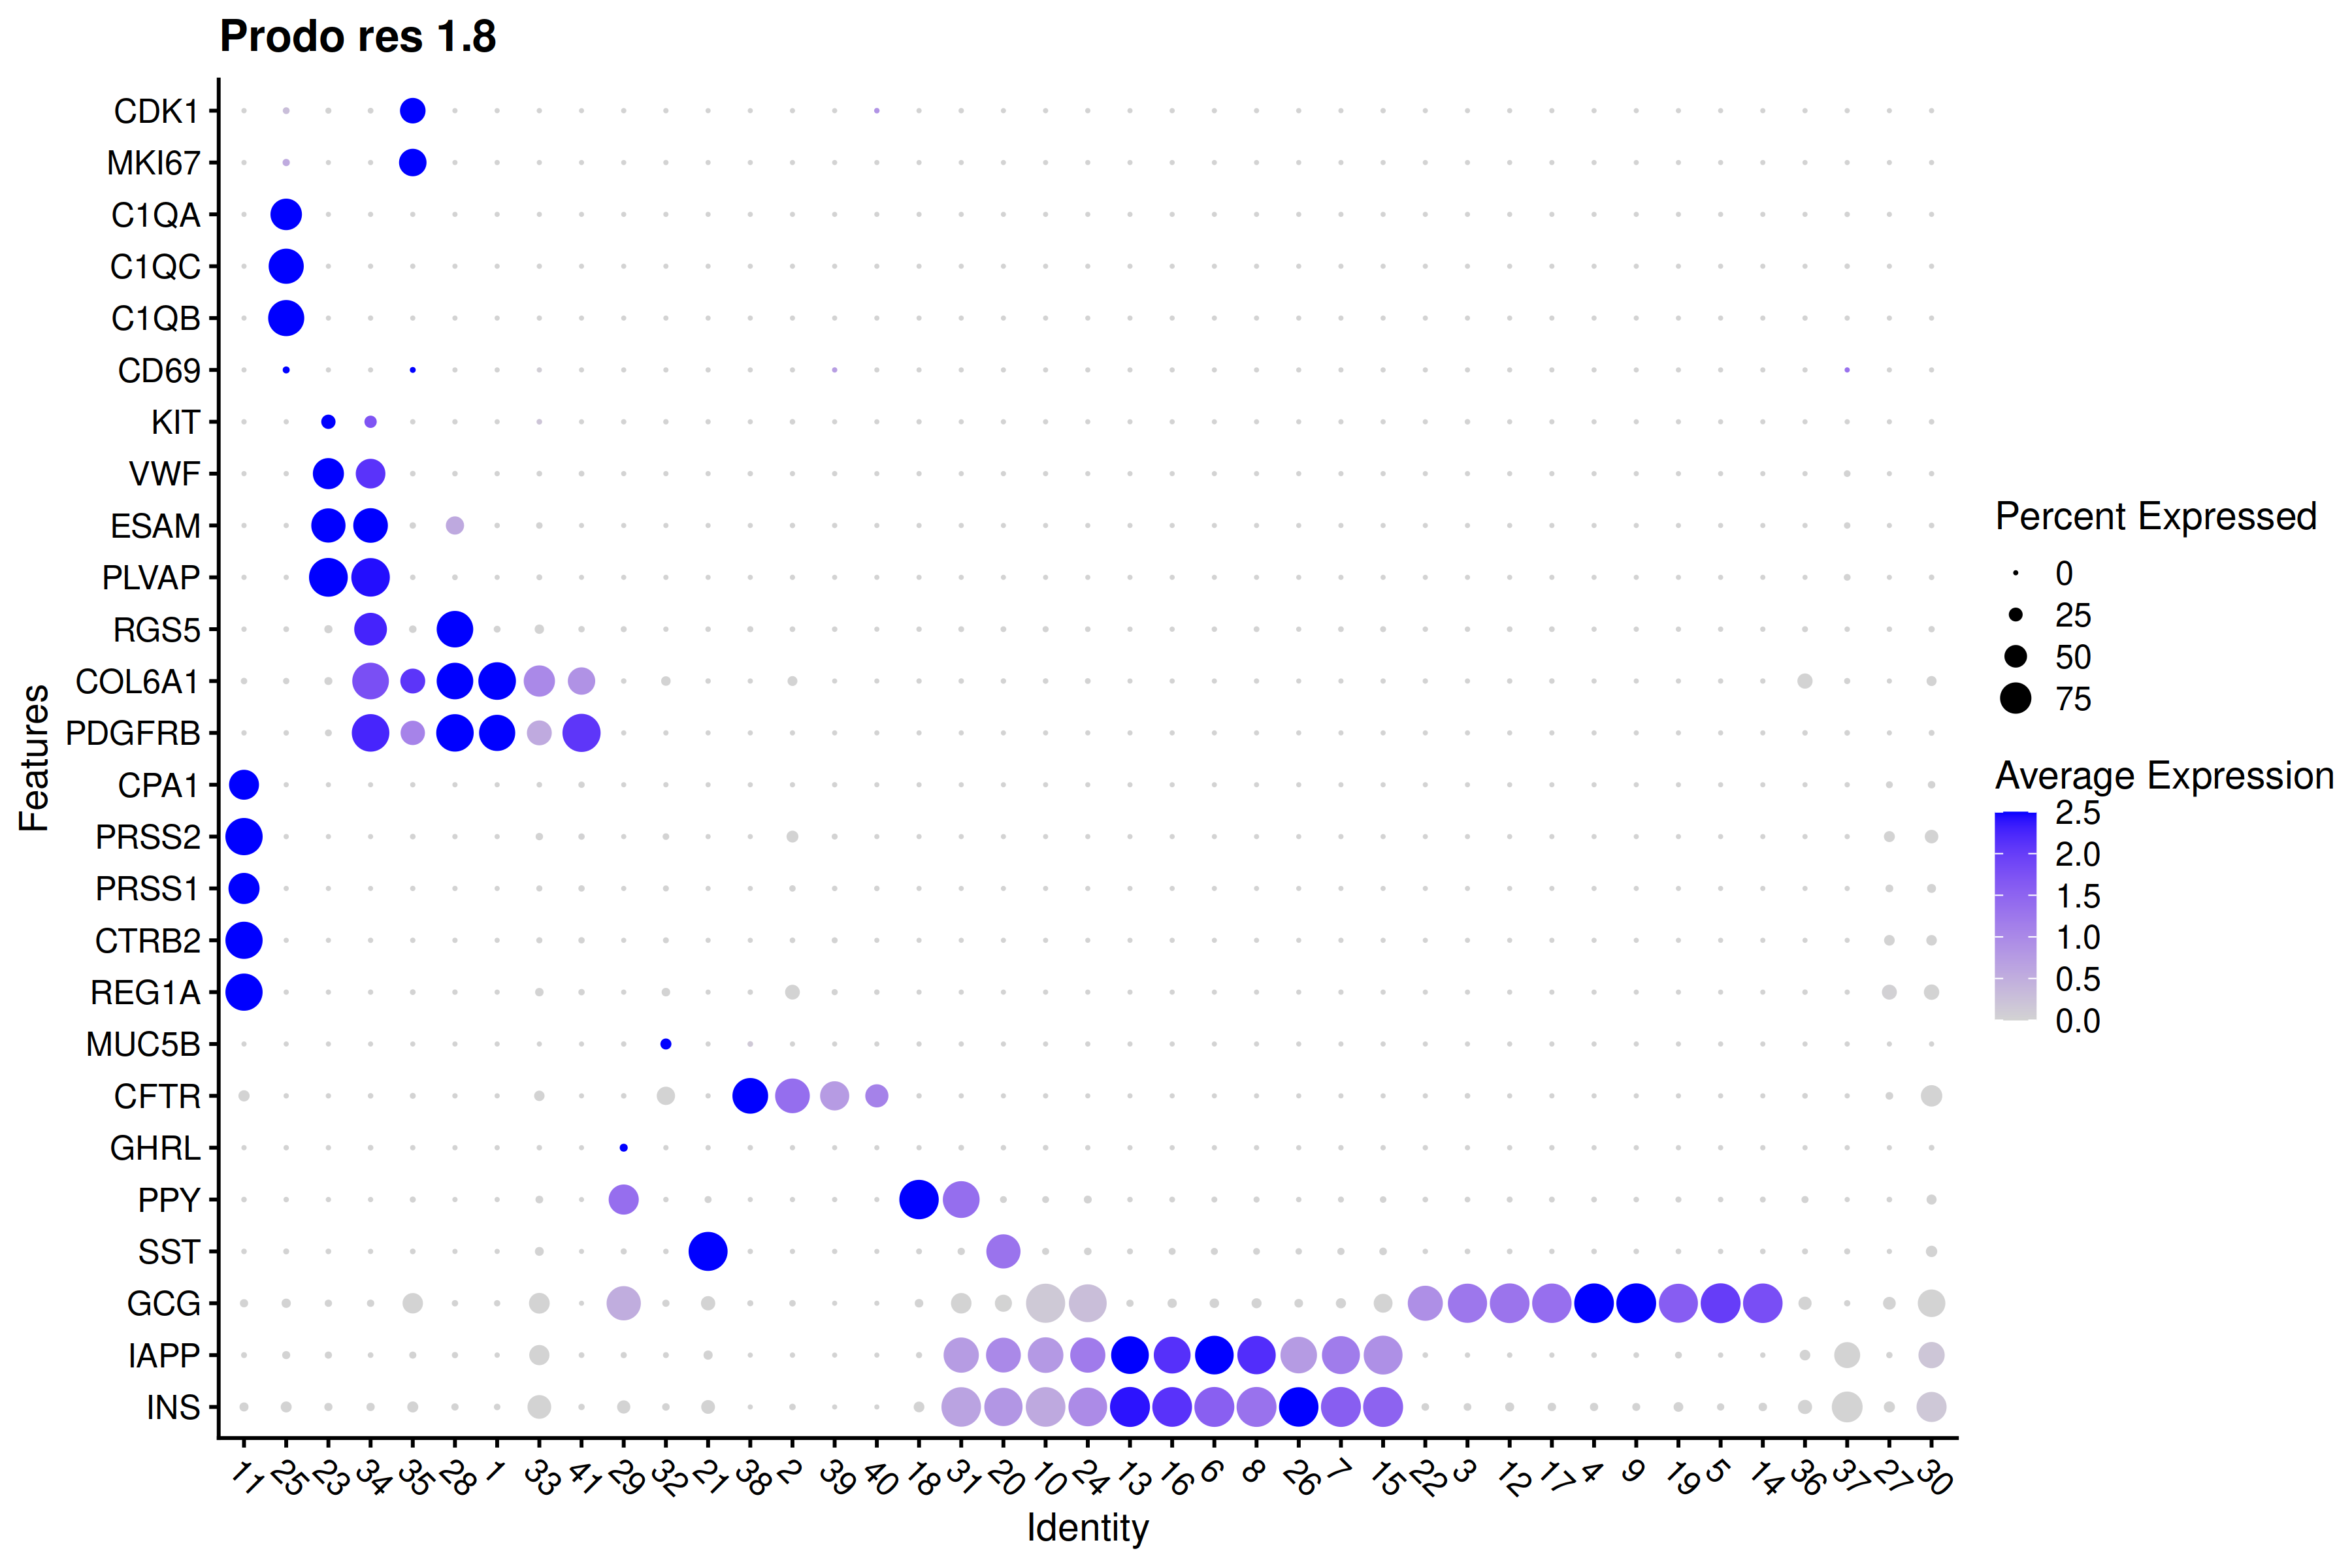

In [17]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 300)

DotPlot(rna, features = markers, cluster.idents = TRUE, col.min = 0, scale = T) +
  theme(axis.text.x = element_text(angle = -45, hjust = 0)) + coord_flip() + ggtitle("Prodo res 1.8")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



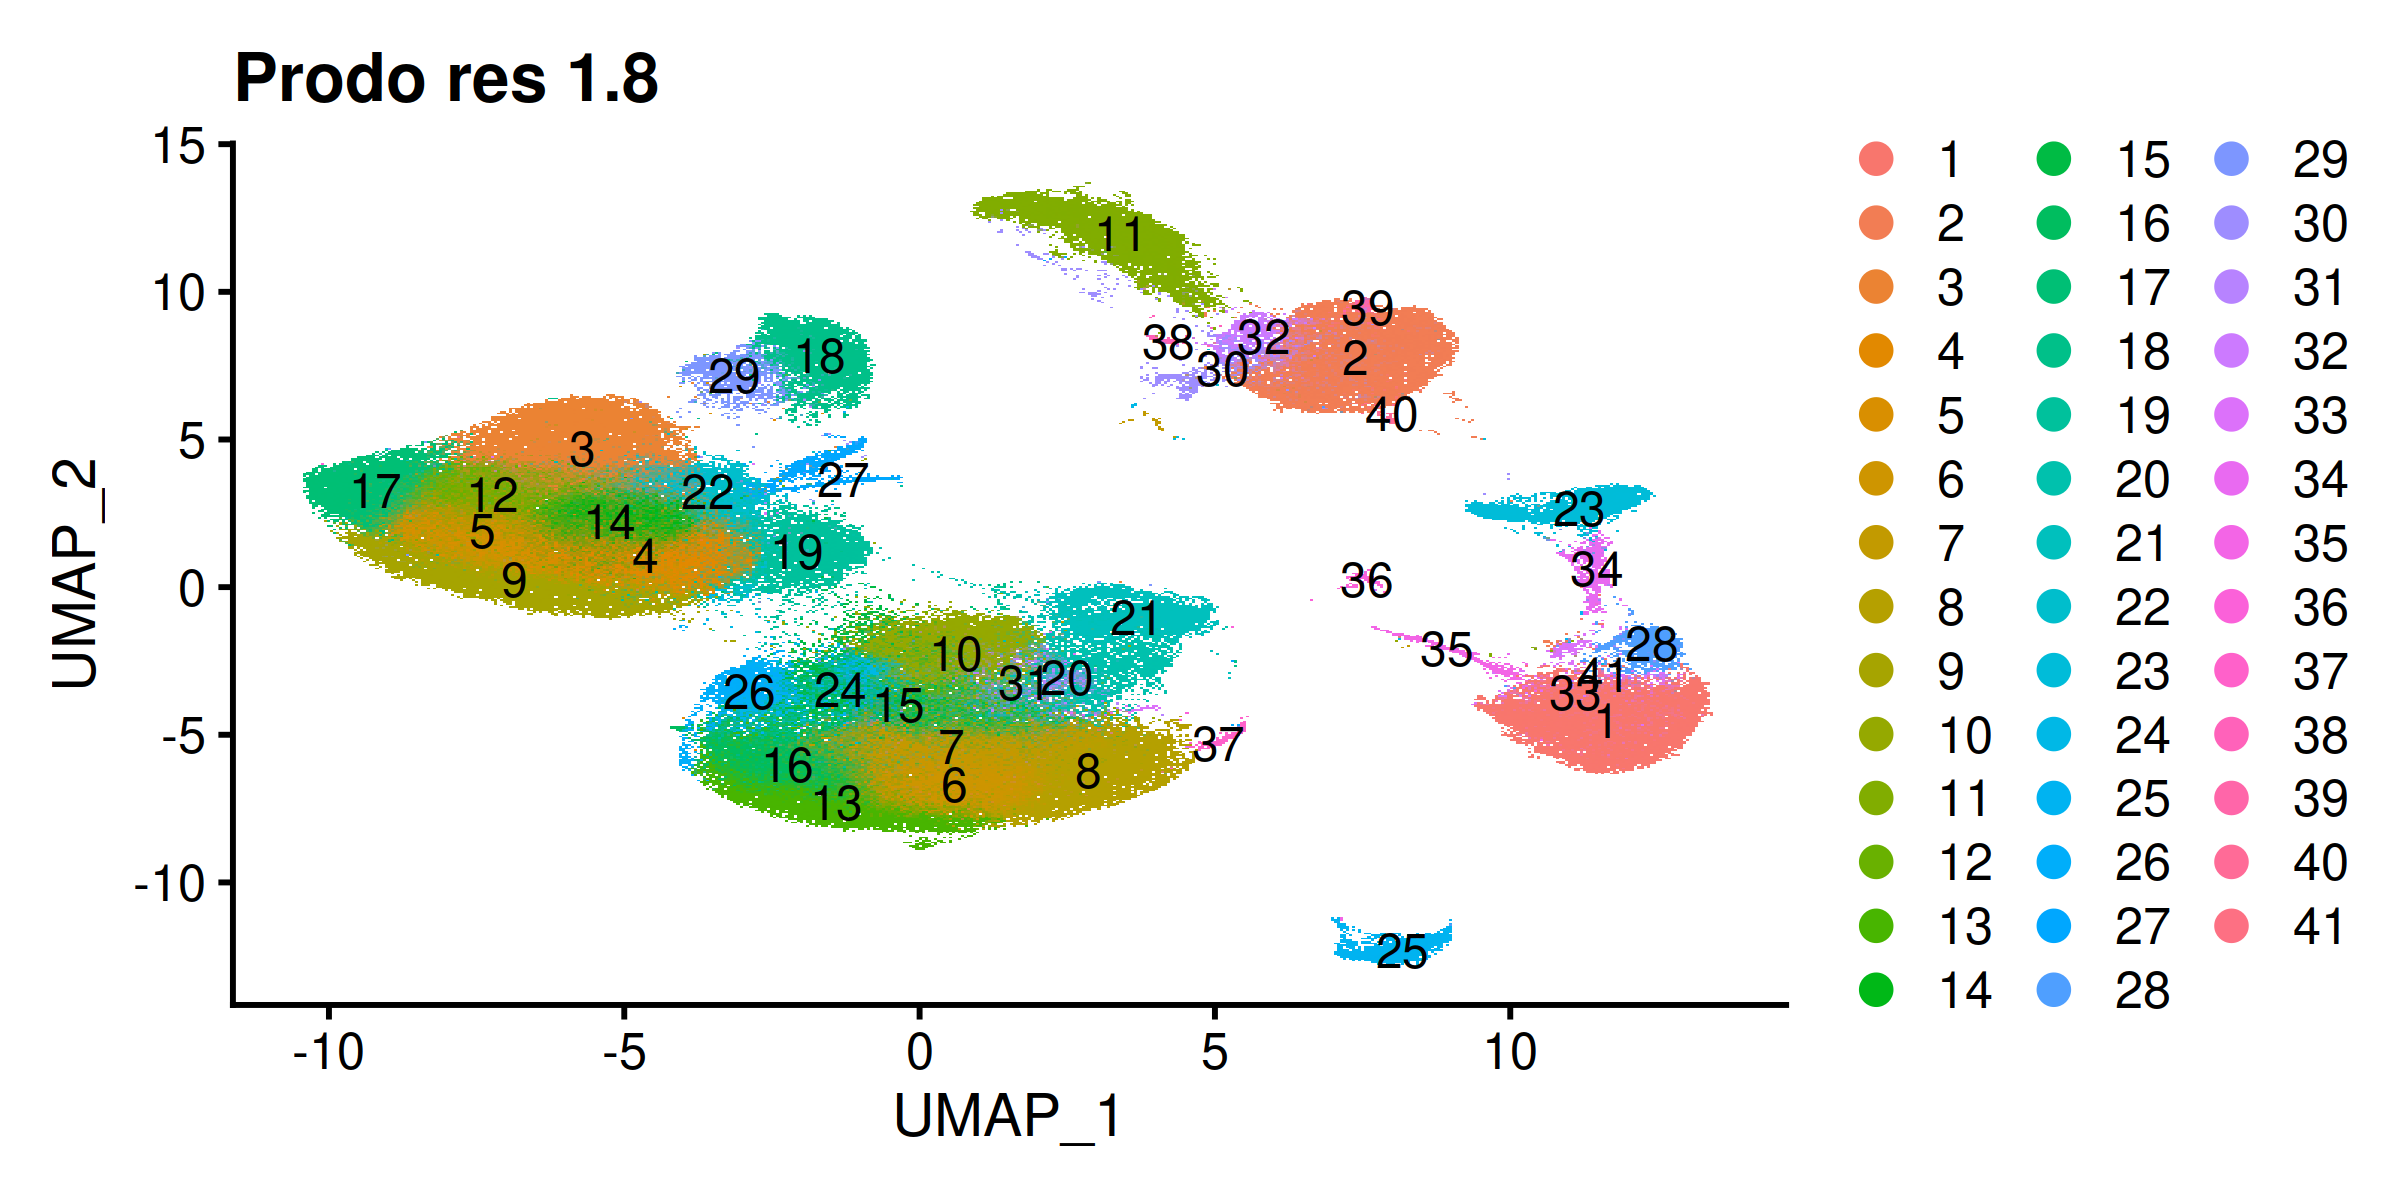

In [18]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300)
DimPlot(rna, label = T, repel = F) + ggtitle("Prodo res 1.8")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

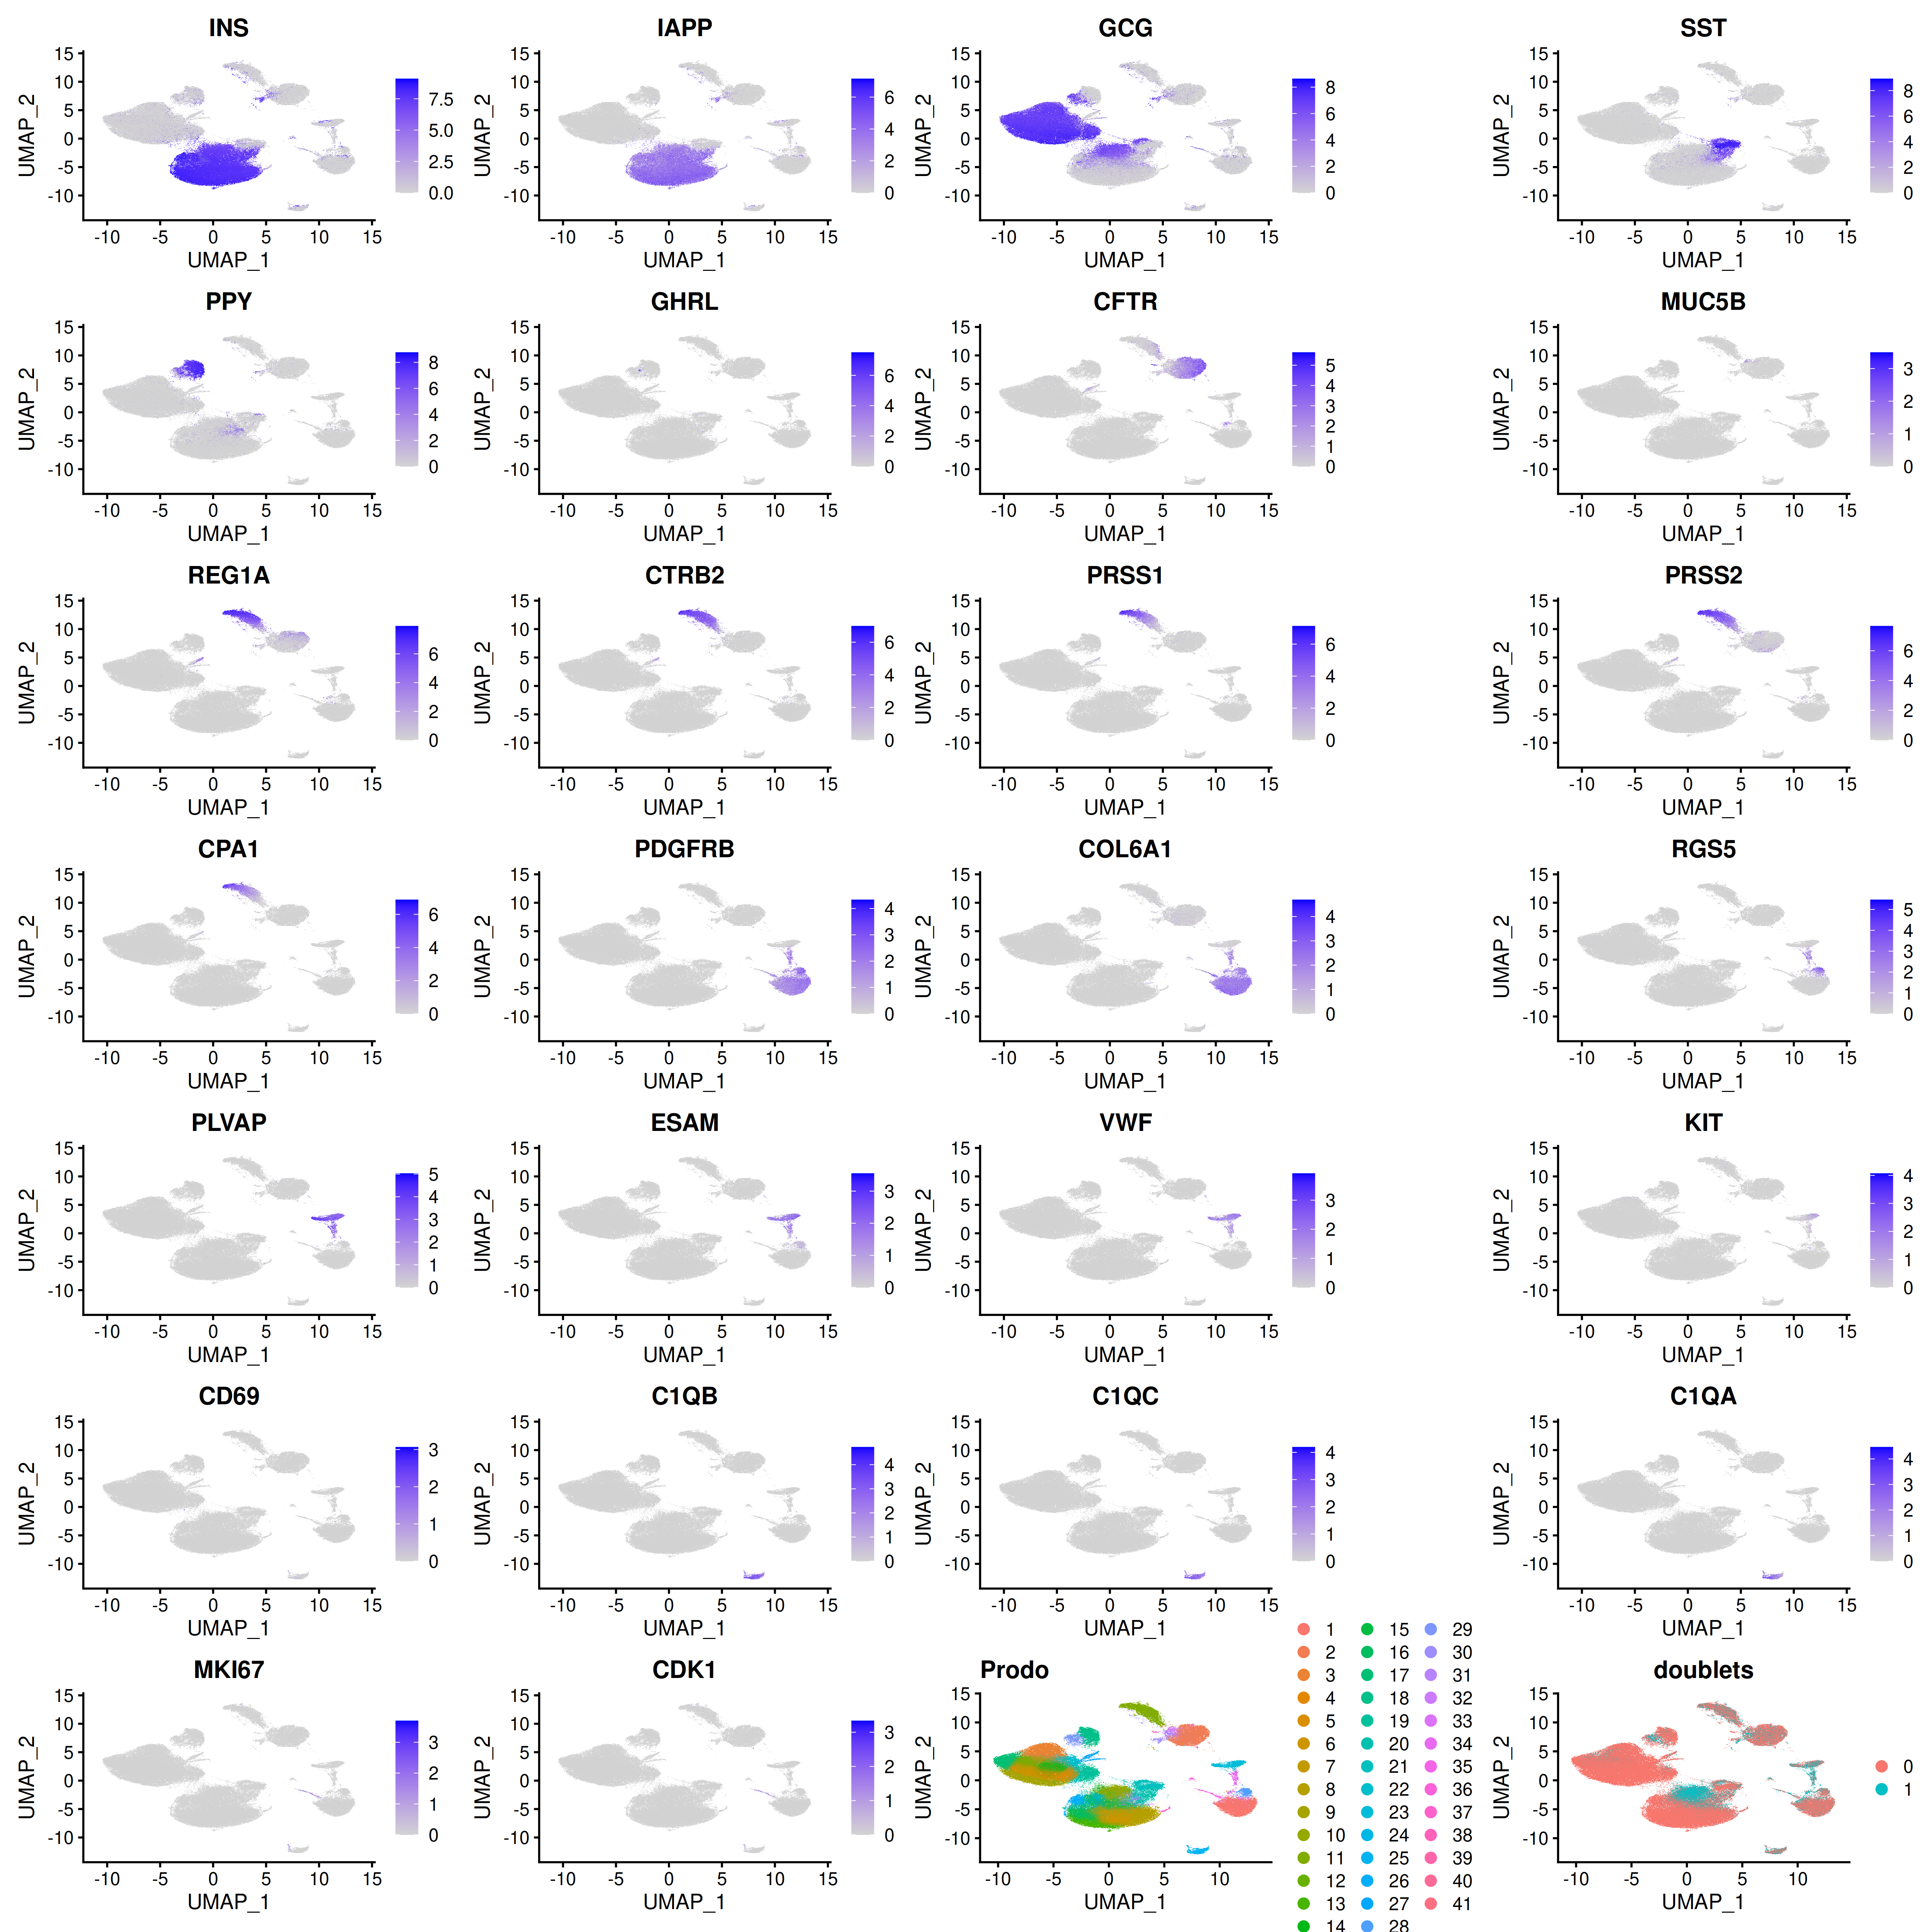

In [19]:
p1 <- DimPlot(rna, label = F) + ggtitle("Prodo")
p2 <- DimPlot(rna, group.by = "to_remove") + ggtitle("doublets")
p <- FeaturePlot(rna, features = markers) + p1 + p2

options(repr.plot.width = 18, repr.plot.height = 18, repr.plot.res = 300)
p

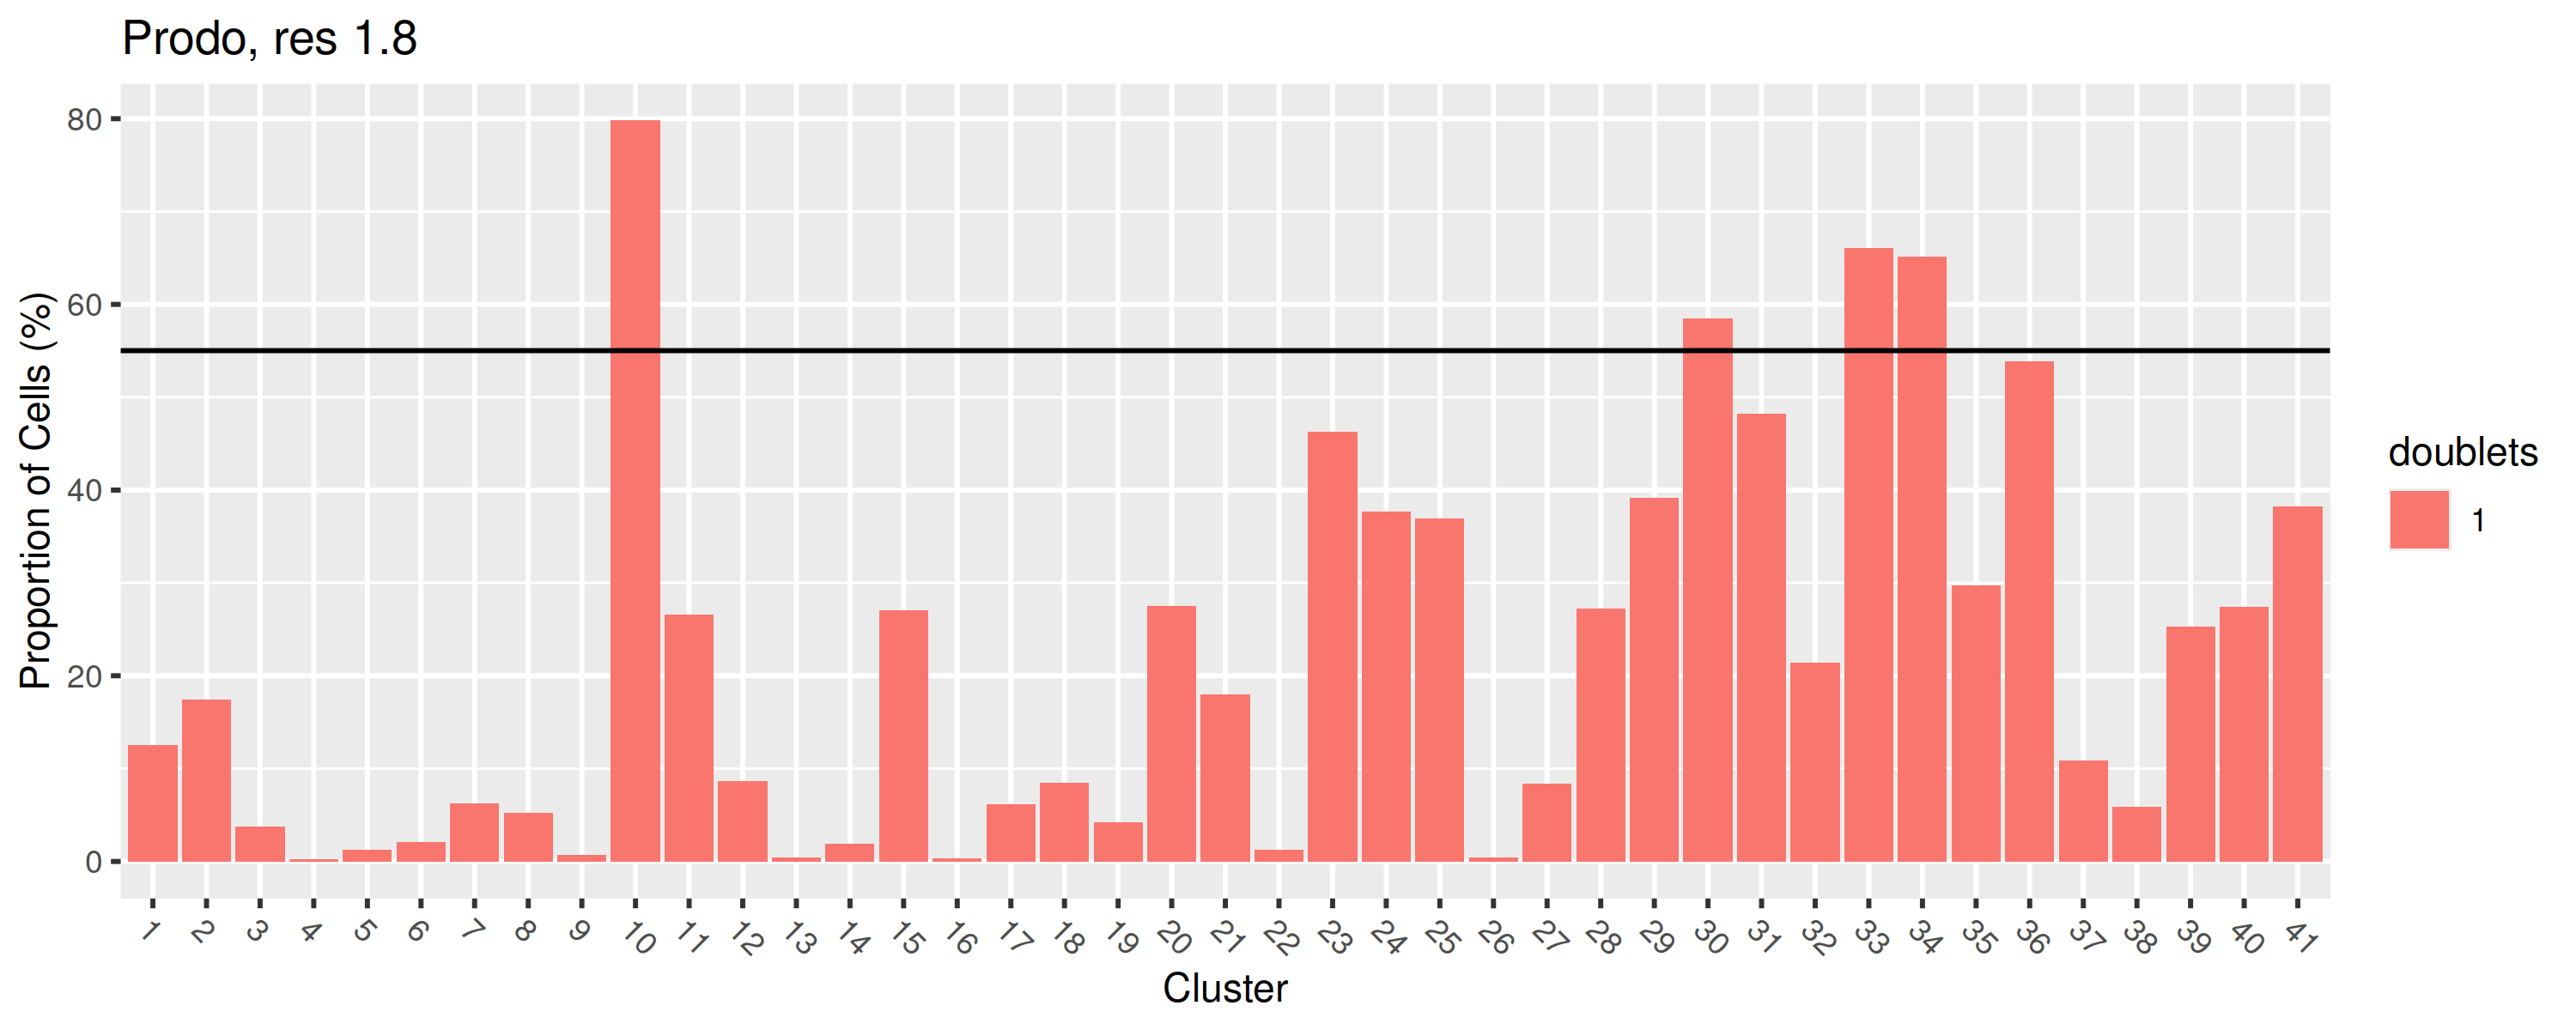

In [21]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
ggData = data.frame(prop.table(table(rna$to_remove, rna$`RNA_snn_res.1.8`), margin = 2))
colnames(ggData) = c("doublets", "cluster", "value")
ggplot(ggData[ggData$doublets == 1,], aes(cluster, value*100, fill = doublets)) +
  geom_col() + xlab("Cluster") + ylab("Proportion of Cells (%)") + ggtitle("Prodo, res 1.8") + 
  theme(axis.text.x = element_text(angle = -45, hjust = 0)) + 
  geom_hline(yintercept = 0.55*100)

In [22]:
ggData[ggData$doublets == 1 & ggData$value > 0.55, "cluster"]

[1] 10 30 33 34
41 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 41

In [23]:
rna@meta.data$to_remove <- ifelse(rna@meta.data$`RNA_snn_res.1.8` %in% c(10, 30, 33, 34), 1, rna@meta.data$to_remove)

In [ ]:
#write.table(rna@meta.data[rna@meta.data$to_remove == 1, "rownames"],
#            paste0("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/doubletfinder_round1/nonDup_proteinCoding/Prodo_indivDblts.txt"), quote = F, sep = "\t", row.names = F)